In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2024-02-10 12:00:11.065927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 12:00:11.066033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 12:00:11.211158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [6]:
test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [8]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [9]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [12]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['pineapple' 'beetroot' 'spinach' 'peas' 'sweetcorn' 'eggplant' 'paprika'
 'ginger' 'apple' 'cucumber' 'cabbage' 'corn' 'turnip' 'potato' 'raddish'
 'banana' 'lemon' 'bell pepper' 'tomato' 'cauliflower' 'pomegranate'
 'sweetpotato' 'pear' 'grapes' 'mango' 'kiwi' 'capsicum' 'lettuce'
 'orange' 'carrot' 'onion' 'soy beans' 'chilli pepper' 'garlic'
 'watermelon' 'jalepeno']


In [14]:
train_df.head(10)

,Filepath,Label
0,../input/fruit-and-vegetable-image-recognition...,pineapple
1,../input/fruit-and-vegetable-image-recognition...,beetroot
2,../input/fruit-and-vegetable-image-recognition...,pineapple
3,../input/fruit-and-vegetable-image-recognition...,spinach
4,../input/fruit-and-vegetable-image-recognition...,peas
5,../input/fruit-and-vegetable-image-recognition...,sweetcorn
6,../input/fruit-and-vegetable-image-recognition...,eggplant
7,../input/fruit-and-vegetable-image-recognition...,spinach
8,../input/fruit-and-vegetable-image-recognition...,pineapple
9,../input/fruit-and-vegetable-image-recognition...,paprika


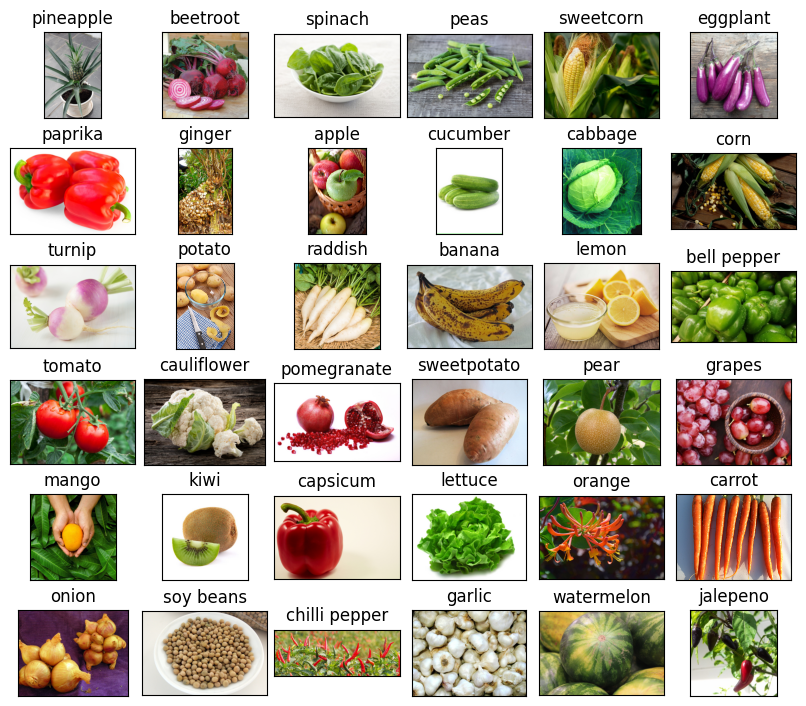

In [15]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [18]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [19]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [20]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 114s 1s/step - loss: 1.7881 - accuracy: 0.5255 - val_loss: 0.4792 - val_accuracy: 0.8772
Epoch 2/5
87/87 [==============================] - 74s 850ms/step - loss: 0.5771 - accuracy: 0.8133 - val_loss: 0.3093 - val_accuracy: 0.9192
Epoch 3/5
87/87 [==============================] - 74s 844ms/step - loss: 0.3462 - accuracy: 0.8950 - val_loss: 0.2388 - val_accuracy: 0.9311
Epoch 4/5
87/87 [==============================] - 74s 846ms/step - loss: 0.2191 - accuracy: 0.9360 - val_loss: 0.2031 - val_accuracy: 0.9641
Epoch 5/5
87/87 [==============================] - 73s 838ms/step - loss: 0.1423 - accuracy: 0.9561 - val_loss: 0.2080 - val_accuracy: 0.9551


In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 10s 868ms/step


['pear',
 'mango',
 'kiwi',
 'onion',
 'cucumber',
 'pear',
 'potato',
 'soy beans',
 'cabbage',
 'onion',
 'pear',
 'beetroot',
 'beetroot',
 'mango',
 'banana',
 'pineapple',
 'raddish',
 'sweetcorn',
 'turnip',
 'carrot',
 'potato',
 'kiwi',
 'cauliflower',
 'raddish',
 'mango',
 'pomegranate',
 'raddish',
 'corn',
 'grapes',
 'lettuce',
 'lettuce',
 'watermelon',
 'turnip',
 'soy beans',
 'jalepeno',
 'cauliflower',
 'cauliflower',
 'mango',
 'sweetpotato',
 'paprika',
 'jalepeno',
 'carrot',
 'spinach',
 'pomegranate',
 'cabbage',
 'capsicum',
 'carrot',
 'apple',
 'grapes',
 'cauliflower',
 'apple',
 'eggplant',
 'chilli pepper',
 'eggplant',
 'lemon',
 'watermelon',
 'peas',
 'apple',
 'capsicum',
 'kiwi',
 'lemon',
 'jalepeno',
 'garlic',
 'peas',
 'peas',
 'pear',
 'lettuce',
 'cabbage',
 'turnip',
 'banana',
 'ginger',
 'grapes',
 'mango',
 'turnip',
 'capsicum',
 'ginger',
 'apple',
 'bell pepper',
 'peas',
 'paprika',
 'capsicum',
 'ginger',
 'turnip',
 'grapes',
 'spinach'

In [23]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [25]:
img = output('../input/fruit-and-vegetable-image-recognition/test/cabbage/Image_1.jpg')
img

1/1 [==============================] - 0s 37ms/step


'cabbage'

In [26]:
model.save('Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
model.save('Modell.sav')